# Model inversion for prep_aria.py (ARIAtools > Mintpy)

Notebook to preform inversion of double-difference model observations to get model values at SAR acquisitions dates
1. generate double-difference stack from existing ERA5.h5 stack
2. invert double-difference pairs to obtain SAR acquisitions model values (in this case tropospheric total delay)

### NOTES
For full integration, **ifgram_inversion.py** and **stack.py/ class ifgramStack** need to be modify to added layers other than unwrappedPhase

Requirements:
1. network need to be connected, all pairs after the gap get wrong estimate
2. SAR acquisition date needs to have min 2 differential observations, if not will give wrong estimate

In [1]:
# Load needed modules
import numpy as np
from matplotlib import pyplot as plt

#mintpy modules
from mintpy.objects import ifgramStack, cluster, timeseries
from mintpy.utils import readfile, ptime, writefile

## Functions
### Create differential model observations

In [2]:
def generate_diff_model(model_input_h5 : str,
                        model_output_name : str,
                        date12_list : list,
                        bperp12 : np.ndarray,
                        length : np.int16,
                        width : np.int16,
                        metadata : dict,
                        drop_flag : np.bool_ = None) -> None:
    import h5py
    from tqdm import tqdm

    # Function to create diff
    def _make_diff(model_stack, date12):
        date1, date2 = ptime.yyyymmdd(date12.split('_'))
        # read date1
        tropo1 = model_stack.read(date1, print_msg=False)
        tropo2 = model_stack.read(date2, print_msg=False)
        dif_tropo = tropo2 - tropo1 
        #Re-reference - SKIP for now, but should be taken into consideration
        #dif_tropo -= dif_tropo[ref_y, ref_x]

        return dif_tropo
    
    # Create diferential model.h5 file
    metadata['FILE_TYPE'] = 'ifgramStack'
    metadata['UNIT'] = 'm'
    #use the first date as reference
    metadata['REF_DATE'] = date12_list[0]
    num_pairs = bperp12.shape[0]

    #get dates numpy array for h5
    date12_array = np.array(list(map(lambda x: x.split('_'), date12_list)), dtype='S8')

    # creat dict for model.h5 layout
    # NOTE: Need to use layer naming unwrappedPhase as ifgramStack object does not support
    # other options at the moment
    # NOTE: maybe could play with dropIfgram to filter data, leave only sequentials
    # but pay attentation to have connected network

    if drop_flag is None:
        drop_flag = np.bool_(np.ones(num_pairs))


    ds_name_dict = {
        "date"       : [date12_array.dtype, (num_pairs, 2), date12_array],
        "bperp"      : [np.float32,  (num_pairs,), bperp12],
        "dropIfgram" : [np.bool_, (num_pairs,), drop_flag],
        "unwrapPhase" : [np.float32,  (num_pairs, length, width), None],
    }
    print(f'Creating {model_output_name}')
    writefile.layout_hdf5(model_output_name, ds_name_dict, metadata=metadata)

    # Differentiating model observations
    # Open model file
    modelObj = readfile.timeseries(model_input_h5)

    # Writing to h5 
    with h5py.File(model_output_name,'a') as f:
        for i, date12 in tqdm(enumerate(date12_list), total=len(date12_list)):
            f['unwrapPhase'][i] =_make_diff(modelObj, date12)
    

### Plot network

In [3]:
# Vizualize network of generated pairs
from datetime import datetime
def yyyymmdd2decimalyear(dates):
    '''
    Convert date to decimal years format according to convention that JPL uses
    for GIPSY timeseries (reference epoch 2000-01-01)
    '''
    dates = dates.astype('datetime64[s]')
    return 2000 + np.float64(dates - np.datetime64('2000-01-01')) / 86400 / 365.25

# MG need to check the func below as it does not always rutrn the right date (get one before)
def decimalyear2yyymmdd(dates):
    '''
    Convert decimal years format (JPL-GIPSY convention) back to date (yyyy-mm-dd)
    format
    '''
    #add one sec to compensate the precison
    seconds = ((dates - 2000) * 365.25 * 86400 + 2).astype('timedelta64[s]')
    return (np.datetime64('2000-01-01') + seconds).astype('datetime64[D]')

    
def obj_plot_network(input_h5 : str) -> None:
    stack_obj1 = ifgramStack(input_h5)
    stack_obj1.open(print_msg=False)
    # Get metadata
    date_list1 = stack_obj1.get_date_list(dropIfgram=True) # get SAR acquisiton dates
    date12_list1 = stack_obj1.get_date12_list(dropIfgram=True) # get ifg pairs
    bperp_list1 = stack_obj1.get_perp_baseline_timeseries(dropIfgram=True) # get SAR acquisitions perpendicular baseline (first date is zero)

    reference, secondary = [], []

    for d12 in date12_list1:
        d1, d2 = d12.split('_')
        reference.append(yyyymmdd2decimalyear(np.datetime64(datetime.strptime(d1, '%Y%m%d'))))
        secondary.append(yyyymmdd2decimalyear(np.datetime64(datetime.strptime(d2, '%Y%m%d'))))


    #make date and bperp dict
    slc_dict = {}
    for bp, dt in zip(bperp_list1, date_list1):
        dt = yyyymmdd2decimalyear(np.datetime64(datetime.strptime(dt, '%Y%m%d')))
        slc_dict[dt] = bp

    #use bperp as xy for each SAR acquisition date
    pair_dict1 = []

    for ref, sec in zip(reference, secondary):
        pair_dict1.append([ref, slc_dict[ref], sec, slc_dict[sec]])

    pair_dict1 = np.array(pair_dict1, dtype=np.float32)
    print('Number of pairs:', pair_dict1.shape[0])
    #plot
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.plot([pair_dict1[:, 0],pair_dict1[:,2]], [pair_dict1[:, 1], pair_dict1[:,3]], 'b-o')

    [print(decimalyear2yyymmdd(pd[0]), ':', pd[1],'|-|', decimalyear2yyymmdd(pd[2]), ':', pd[3]) for pd in pair_dict1]


### Invert differential model observations to obtain relative ones for each SAR acquisition date with respect to defined reference date

In [4]:
# Function based on run_ifgram_inversion(inps) in mintpy/ifgram_inversion.py
def run_ifgram_inversion(model_stackFile : str,
                         model_output: str,
                         cluster_flag : bool = False,
                         cluster_num_workers : int = 4) -> None:
    from tqdm import tqdm
    # Create hdf layout for the inversion output

    #  1.1 open differential model.h5 stack
    '''
     hdf file needs to have:
     ds_name_dict = {
        "date"       : [date12_array.dtype, (num_pairs, 2), date12_array],
        "bperp"      : [np.float32,  (num_pairs,), bperp12],
        "dropIfgram" : [np.bool_, (num_pairs,), np.bool_(np.ones(num_pairs))],
        "unwrapPhase" : [np.float32,  (num_pairs, length, width), None],
    }
    ''' 
    modelObj = ifgramStack(model_stackFile)  #model.h5
    modelObj.open()

    # get dates
    date12_list = modelObj.get_date12_list(dropIfgram=True)
    date_list = modelObj.get_date_list(dropIfgram=True)
    length, width = modelObj.length, modelObj.width

    # 1.2 design matrix
    A = modelObj.get_design_matrix4timeseries(date12_list)[0]
    num_pair, num_date = A.shape[0], A.shape[1]+1
    print('number of interferograms: {}'.format(num_pair))
    print('number of acquisitions  : {}'.format(num_date))
    print('number of lines   : {}'.format(length))
    print('number of columns : {}'.format(width))

    # initiate output
    meta = dict(modelObj.metadata)
    meta['FILE_TYPE'] = 'timeseries'
    meta['UNIT'] = 'm'
    meta['REF_DATE'] = date_list[0]

    dates = np.array(date_list, dtype=np.string_)
    pbase = modelObj.get_perp_baseline_timeseries(dropIfgram=True)
    # wrapping factor 
    phase2range = -1 * float(modelObj.metadata['WAVELENGTH']) / (4.*np.pi) 

    ds_name_dict = {
    "date"       : [dates.dtype, (num_date,), dates],
    "bperp"      : [np.float32,  (num_date,), pbase],
    "timeseries" : [np.float32,  (num_date, length, width), None],
    }
    writefile.layout_hdf5(model_output, ds_name_dict, metadata=meta)

    # 2. INVERSION
    from mintpy.ifgram_inversion import run_ifgram_inversion_patch
    # Get reference pixel value
    refPhase = modelObj.get_reference_phase(unwDatasetName='unwrapPhase',
                                            dropIfgram=True)

    box_list, num_box = modelObj.split2boxes(max_memory=2) #max 2gb

    # 2.1 prepare the input arguments for *_patch()
    # set offset into obs_ds_name to follow offset inv
    data_kwargs = {
        "ifgram_file"       : model_stackFile,
        "obs_ds_name"       : 'unwrapPhase',
        'ref_phase'         : refPhase,
        "weight_func"       : 'no',
    }
    # 2.2 invert / write block-by-block
    for i, box in tqdm(enumerate(box_list), total=len(box_list)):
        box_wid = box[2] - box[0]
        box_len = box[3] - box[1]
        if num_box > 1:
            print('\n------- processing patch {} out of {} --------------'.format(i+1, num_box))
            print('box width:  {}'.format(box_wid))
            print('box length: {}'.format(box_len))

        # update box argument in the input data
        data_kwargs['box'] = box

        if not cluster_flag:
            # non-parallel
            ts, ts_cov, inv_quality, num_inv_obs = run_ifgram_inversion_patch(**data_kwargs)[:-1]

        else:
            # parallel
            print('\n\n------- start parallel processing using Dask -------')

            # initiate the output data
            ts = np.zeros((num_date, box_len, box_wid), np.float32)
            ts_cov =  None
            inv_quality = np.zeros((box_len, box_wid), np.float32)
            num_inv_obs = np.zeros((box_len, box_wid), np.float32)

            # initiate dask cluster and client
            cluster_obj = cluster.DaskCluster('local', str(cluster_num_workers))
            cluster_obj.open()

            # run dask
            ts, ts_cov, inv_quality, num_inv_obs = cluster_obj.run(
                func=run_ifgram_inversion_patch,
                func_data=data_kwargs,
                results=[ts, ts_cov, inv_quality, num_inv_obs])

            # close dask cluster and client
            cluster_obj.close()

            print('------- finished parallel processing -------\n\n')

        # revert conversion from radians to meters as it is not needed
        # Note: compensate for ifgram_inversion.py line 909
        # double-difference model observations are in meters not radians
        print('returning model observations unit to original')
        ts = ts / phase2range

        # write it local
        block = [0, num_date, box[1], box[3], box[0], box[2]]
        writefile.write_hdf5_block(model_output,
                                   data=ts,
                                   datasetName='timeseries',
                                   block=block)

In [5]:
# Vizualize
def plot_tropo(input_era, 
                inv_era, 
                ref_era, 
                ref_y, 
                ref_x, 
                title=None):
                
    # Reference absolute model obs to the reference date
    ie1 = (input_era - ref_era).copy()
    ie2 = inv_era.copy() #/ phase2range

    #re-reference to the same reference pixel
    clim= [-0.03, 0.03]
    ie1 -= ie1[ref_y, ref_x]
    fig, ax = plt.subplots(1, 3, sharey=True)
    im1 = ax[0].imshow(ie1, clim=clim)
    im2 = ax[1].imshow(ie2, clim=clim)
    im3 = ax[2].imshow(ie1 - ie2, clim=clim) 

    ax[0].set_title('ERA5')
    ax[1].set_title('invERA5')
    ax[2].set_title('ERA5 - invERA5')

    fig.colorbar(im1, ax=ax[0], location='bottom')
    fig.colorbar(im2, ax=ax[1], location='bottom')
    fig.colorbar(im3, ax=ax[2], location='bottom')

    if title is not None:
        fig.suptitle(title, fontsize=30)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Workflow

In [88]:
# Get needed metadata from interferogram stack - pairs, dates

# Load ifg stack data
stack_obj = ifgramStack('inputs/ifgramStack.h5')
stack_obj.open(print_msg=False)
# Get metadata
metadata = stack_obj.get_metadata()
date_list = stack_obj.get_date_list() # get SAR acquisiton dates
date12_list = stack_obj.get_date12_list() # get ifg pairs
bperp12 = stack_obj.pbaseIfgram # get ifg pair perpendicular baselines
bperp_list = stack_obj.get_perp_baseline_timeseries() # get SAR acquisitions perpendicular baseline (first date is zero)
length, width = stack_obj.length, stack_obj.width # raster dimensions
#reference point
ref_y, ref_x = int(metadata['REF_Y']), int(metadata['REF_X'])


## Test it out on 30 pairs

Creating differential model observations for each ifg pair
Creating rERA5.h5
--------------------------------------------------
create HDF5 file: rERA5.h5 with w mode
create dataset  : date        of |S8                       in size of (30, 2)              with compression = None
create dataset  : bperp       of <class 'numpy.float32'>   in size of (30,)                with compression = None
create dataset  : dropIfgram  of <class 'numpy.bool_'>     in size of (30,)                with compression = None
create dataset  : unwrapPhase of <class 'numpy.float32'>   in size of (30, 3926, 5534)     with compression = None
close  HDF5 file: rERA5.h5


100%|██████████| 30/30 [00:21<00:00,  1.42it/s]

Number of pairs: 30
2017-01-01 : 0.0 |-| 2017-01-08 : -50.986755
2017-01-01 : 0.0 |-| 2017-01-13 : -27.955963
2017-01-01 : 0.0 |-| 2017-01-20 : -13.75345
2017-01-01 : 0.0 |-| 2018-01-02 : -140.9761
2017-01-08 : -50.986755 |-| 2017-01-13 : -27.955963
2017-01-08 : -50.986755 |-| 2017-01-20 : -13.75345
2017-01-08 : -50.986755 |-| 2017-01-26 : -59.976677
2017-01-08 : -50.986755 |-| 2018-01-09 : 26.282059
2017-01-13 : -27.955963 |-| 2017-01-20 : -13.75345
2017-01-13 : -27.955963 |-| 2017-01-26 : -59.976677
2017-01-13 : -27.955963 |-| 2017-01-31 : 22.195833
2017-01-13 : -27.955963 |-| 2018-01-14 : -94.78819
2017-01-20 : -13.75345 |-| 2017-01-26 : -59.976677
2017-01-20 : -13.75345 |-| 2017-01-31 : 22.195833
2017-01-20 : -13.75345 |-| 2017-02-07 : -78.73982
2017-01-20 : -13.75345 |-| 2018-01-21 : 10.293346
2017-01-26 : -59.976677 |-| 2017-01-31 : 22.195833
2017-01-26 : -59.976677 |-| 2017-02-07 : -78.73982
2017-01-26 : -59.976677 |-| 2017-02-12 : -39.903694
2017-01-26 : -59.976677 |-| 2018-01-

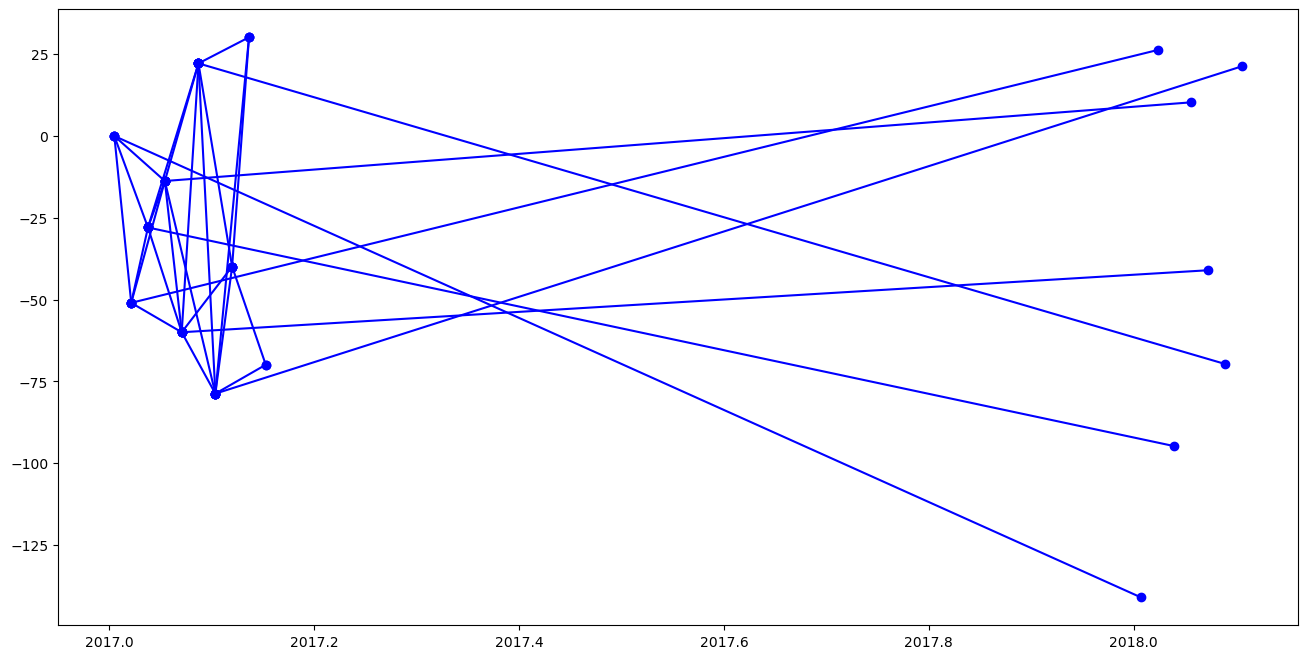

In [89]:
n_ix = 30
print("\033[1m" + 'Creating differential model observations for each ifg pair' + "\033[0m")
generate_diff_model('inputs/ERA5.h5',
                          'rERA5.h5',
                          date12_list[:n_ix],
                          bperp12[:n_ix],
                          length,
                          width,
                          metadata)

# PLOT
obj_plot_network('rERA5.h5')

In [90]:
print("\033[1m" + 'Invert differential model observations' + "\033[0m")
run_ifgram_inversion('rERA5.h5', 'tERA5.h5')

Invert differential model observations
open ifgramStack file: rERA5.h5
number of interferograms: 30
number of acquisitions  : 17
number of lines   : 3926
number of columns : 5534
--------------------------------------------------
create HDF5 file: tERA5.h5 with w mode
create dataset  : date       of |S8                       in size of (17,)                with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (17,)                with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (17, 3926, 5534)     with compression = None
close  HDF5 file: tERA5.h5
reference pixel in y/x: (2764, 2142) from dataset: unwrapPhase
maximum memory size: 2.0E+00 GB
split 3926 lines into 5 patches for processing
    with each patch up to 790 lines


  0%|          | 0/5 [00:00<?, ?it/s]


------- processing patch 1 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 0, 5534, 790) * 30 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 3599837 out of 4371860 (82.3%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (3598981 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 7000 pixels: 515 chunks in total ...
chunk 100 / 515
chunk 200 / 515
chunk 300 / 515
chunk 400 / 515
chunk 500 / 515
estimating time-series for pixels with valid unwrapPhase in some ifgrams (856 pixels; 0.0%) ...
[==================================================] 856/856 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.h5 in a mode
writing dataset /timeseries         

 20%|██        | 1/5 [00:16<01:04, 16.21s/it]

close HDF5 file tERA5.h5.

------- processing patch 2 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 790, 5534, 1580) * 30 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 4371860 out of 4371860 (100.0%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (4370493 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 7000 pixels: 625 chunks in total ...
chunk 100 / 625
chunk 200 / 625
chunk 300 / 625
chunk 400 / 625
chunk 500 / 625
chunk 600 / 625
estimating time-series for pixels with valid unwrapPhase in some ifgrams (1367 pixels; 0.0%) ...
[==================================================] 1367/1367 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.

 40%|████      | 2/5 [00:33<00:50, 17.00s/it]

close HDF5 file tERA5.h5.

------- processing patch 3 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 1580, 5534, 2370) * 30 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 4371860 out of 4371860 (100.0%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (4370036 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 7000 pixels: 625 chunks in total ...
chunk 100 / 625
chunk 200 / 625
chunk 300 / 625
chunk 400 / 625
chunk 500 / 625
chunk 600 / 625
estimating time-series for pixels with valid unwrapPhase in some ifgrams (1824 pixels; 0.0%) ...
[==================================================] 1824/1824 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5

 60%|██████    | 3/5 [00:53<00:36, 18.30s/it]

close HDF5 file tERA5.h5.

------- processing patch 4 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 2370, 5534, 3160) * 30 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 4371859 out of 4371860 (100.0%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (4368835 pixels; 99.9%) ...
calculating temporalCoherence in chunks of 7000 pixels: 625 chunks in total ...
chunk 100 / 625
chunk 200 / 625
chunk 300 / 625
chunk 400 / 625
chunk 500 / 625
chunk 600 / 625
estimating time-series for pixels with valid unwrapPhase in some ifgrams (3024 pixels; 0.1%) ...
[==================================================] 3024/3024 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.

 80%|████████  | 4/5 [01:12<00:18, 18.63s/it]

close HDF5 file tERA5.h5.

------- processing patch 5 out of 5 --------------
box width:  5534
box length: 766
reading unwrapPhase in (0, 3160, 5534, 3926) * 30 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 3506429 out of 4239044 (82.7%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (3504939 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 7000 pixels: 501 chunks in total ...
chunk 100 / 501
chunk 200 / 501
chunk 300 / 501
chunk 400 / 501
chunk 500 / 501
estimating time-series for pixels with valid unwrapPhase in some ifgrams (1490 pixels; 0.0%) ...
[==================================================] 1490/1490 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.h5 in a mode
wri

100%|██████████| 5/5 [01:28<00:00, 17.79s/it]

close HDF5 file tERA5.h5.


open timeseries file: tERA5.h5


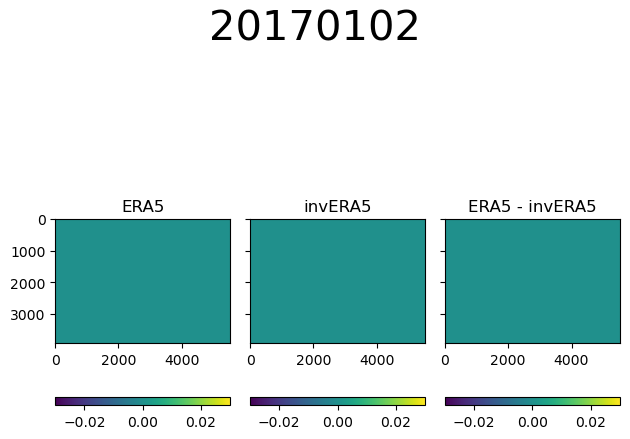

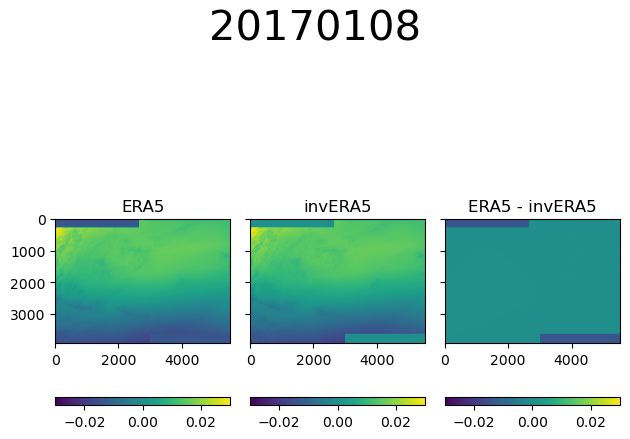

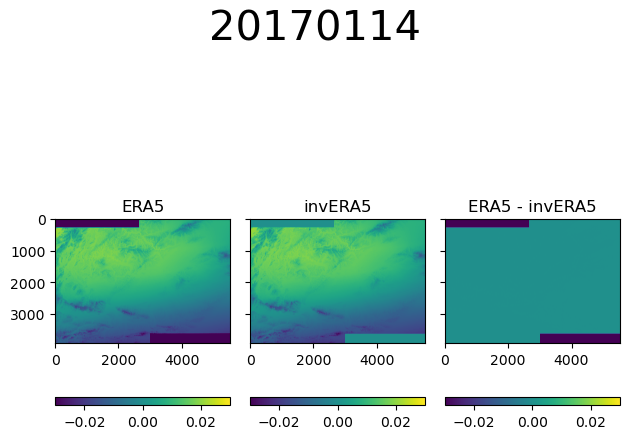

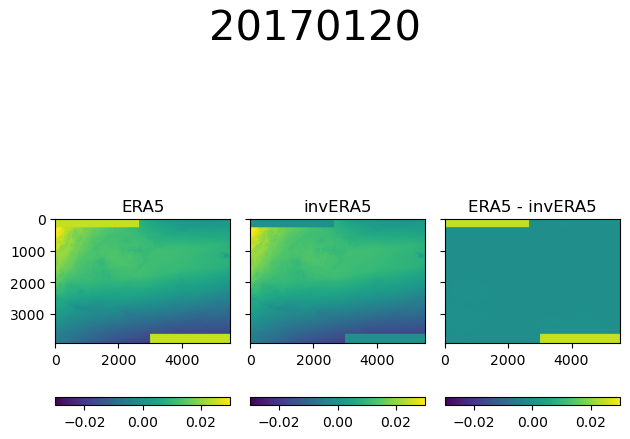

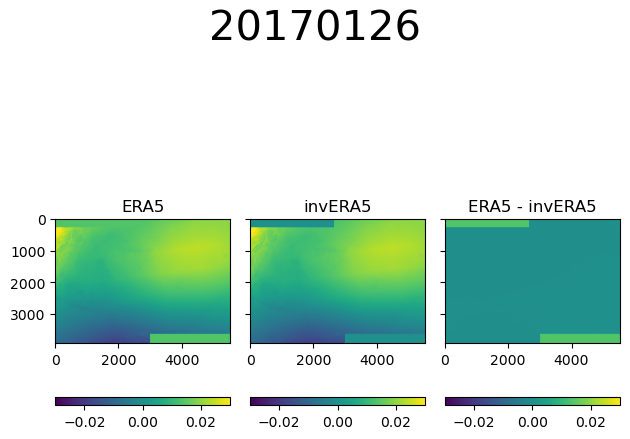

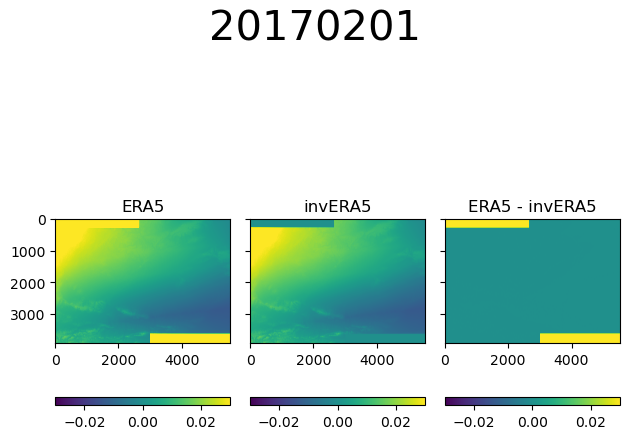

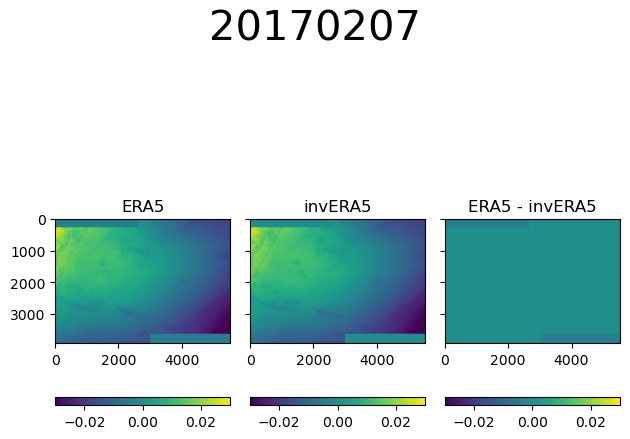

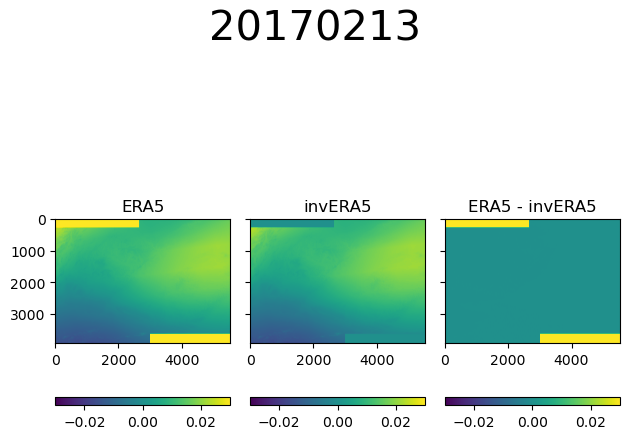

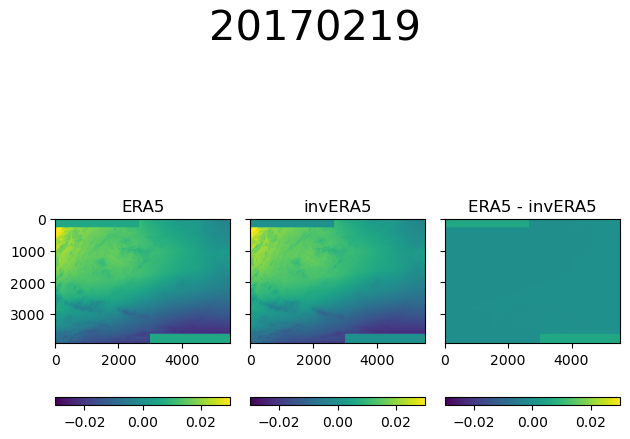

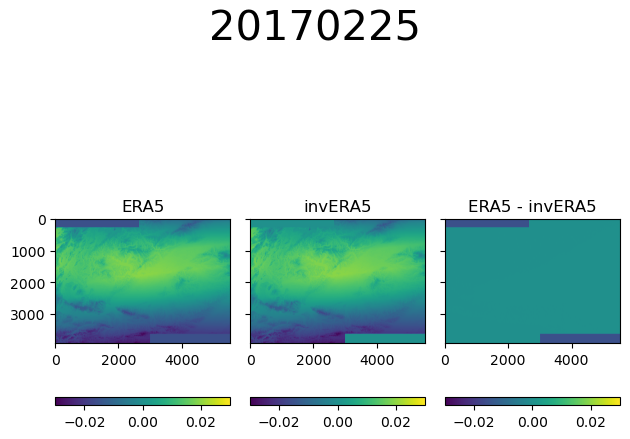

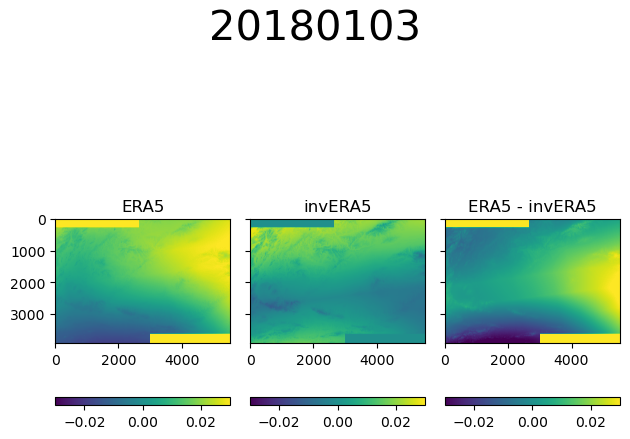

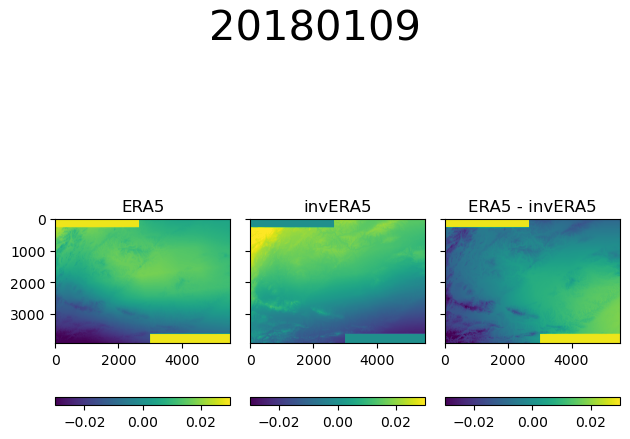

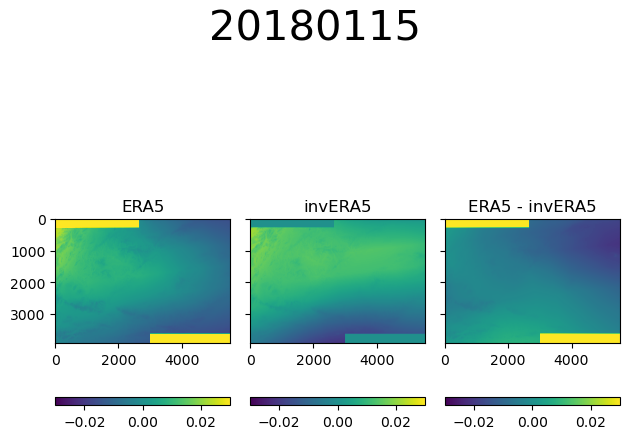

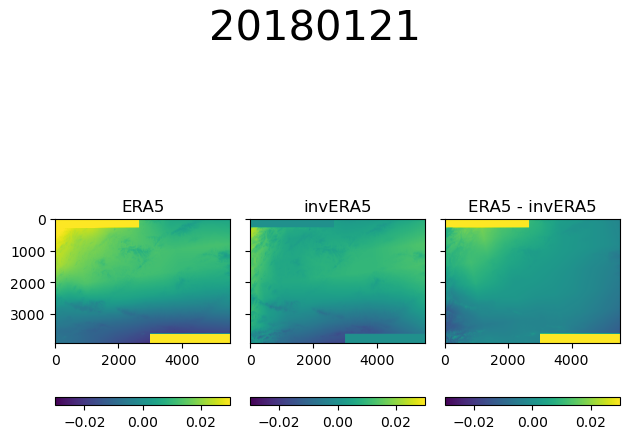

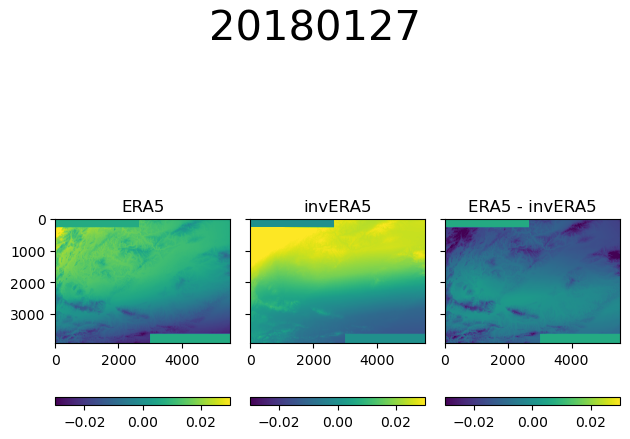

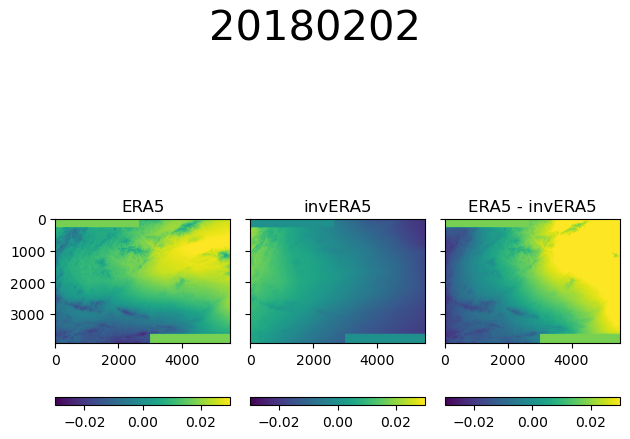

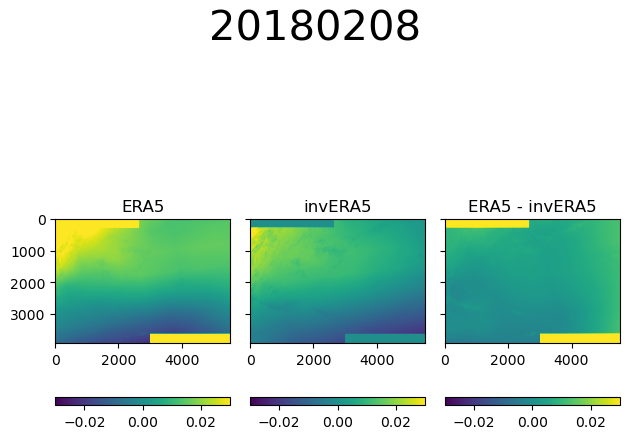

In [91]:
'''
Note it looks like inversion will give wrong estimates if there is only one differential observations with the SAR date inverted for
I would guess we need at least two obs, or could be due to long temp baselines plus no good constrains with num of pairs
'''
#READ inital and output dataset

era5 = readfile.read('inputs/ERA5.h5', datasetName='timeseries')
t_era5 =readfile.read('tERA5.h5', datasetName='timeseries')

#Get dates
modelObj = timeseries('tERA5.h5')  #model.h5
modelObj.open()
dates = modelObj.dateList

#Plot
for e1, e2, d in zip(era5[0], t_era5[0], dates):
    plot_tropo(e1, e2, era5[0][0], ref_y, ref_x, d) #select the first date as reference

## 2. Disconnect the network and try it out

In [92]:
[print(i,'-', dd) for i, dd in enumerate(date12_list[:n_ix])];

0 - 20170102_20170108
1 - 20170102_20170114
2 - 20170102_20170120
3 - 20170102_20180103
4 - 20170108_20170114
5 - 20170108_20170120
6 - 20170108_20170126
7 - 20170108_20180109
8 - 20170114_20170120
9 - 20170114_20170126
10 - 20170114_20170201
11 - 20170114_20180115
12 - 20170120_20170126
13 - 20170120_20170201
14 - 20170120_20170207
15 - 20170120_20180121
16 - 20170126_20170201
17 - 20170126_20170207
18 - 20170126_20170213
19 - 20170126_20180127
20 - 20170201_20170207
21 - 20170201_20170213
22 - 20170201_20170219
23 - 20170201_20180202
24 - 20170207_20170213
25 - 20170207_20170219
26 - 20170207_20170225
27 - 20170207_20180208
28 - 20170213_20170219
29 - 20170213_20170225


In [93]:
# try to drop one DATE as a secondary 
drop_date = ''

drop_flag = []

for d in date12_list:
    drop_flag.append((drop_date in d.split('_')[1]) * -1)
drop_flag = np.bool_(drop_flag)

In [94]:
## NOTE: do not understand why dropIFg is False for dropping pairs, would guess to be opposite 
drop_ixs = [6, 9, 12, 14, 16, 20, 21, 25, 28]
for ix in drop_ixs:
    drop_flag[ix] = False

drop_flag = np.bool_(drop_flag)

[print(i, '-', p,":", d) for i, (p, d) in enumerate(zip(date12_list[:n_ix], drop_flag[:n_ix]))];

0 - 20170102_20170108 : True
1 - 20170102_20170114 : True
2 - 20170102_20170120 : True
3 - 20170102_20180103 : True
4 - 20170108_20170114 : True
5 - 20170108_20170120 : True
6 - 20170108_20170126 : False
7 - 20170108_20180109 : True
8 - 20170114_20170120 : True
9 - 20170114_20170126 : False
10 - 20170114_20170201 : True
11 - 20170114_20180115 : True
12 - 20170120_20170126 : False
13 - 20170120_20170201 : True
14 - 20170120_20170207 : False
15 - 20170120_20180121 : True
16 - 20170126_20170201 : False
17 - 20170126_20170207 : True
18 - 20170126_20170213 : True
19 - 20170126_20180127 : True
20 - 20170201_20170207 : False
21 - 20170201_20170213 : False
22 - 20170201_20170219 : True
23 - 20170201_20180202 : True
24 - 20170207_20170213 : True
25 - 20170207_20170219 : False
26 - 20170207_20170225 : True
27 - 20170207_20180208 : True
28 - 20170213_20170219 : False
29 - 20170213_20170225 : True


Creating differential model observations for each ifg pair
Creating rERA5.h5
--------------------------------------------------
create HDF5 file: rERA5.h5 with w mode
create dataset  : date        of |S8                       in size of (30, 2)              with compression = None
create dataset  : bperp       of <class 'numpy.float32'>   in size of (30,)                with compression = None
create dataset  : dropIfgram  of <class 'numpy.bool_'>     in size of (30,)                with compression = None
create dataset  : unwrapPhase of <class 'numpy.float32'>   in size of (30, 3926, 5534)     with compression = None
close  HDF5 file: rERA5.h5


100%|██████████| 30/30 [00:14<00:00,  2.12it/s]

Number of pairs: 21
2017-01-01 : 0.0 |-| 2017-01-08 : -50.986755
2017-01-01 : 0.0 |-| 2017-01-13 : -27.955965
2017-01-01 : 0.0 |-| 2017-01-20 : -13.75345
2017-01-01 : 0.0 |-| 2018-01-02 : -140.9761
2017-01-08 : -50.986755 |-| 2017-01-13 : -27.955965
2017-01-08 : -50.986755 |-| 2017-01-20 : -13.75345
2017-01-08 : -50.986755 |-| 2018-01-09 : 26.282057
2017-01-13 : -27.955965 |-| 2017-01-20 : -13.75345
2017-01-13 : -27.955965 |-| 2017-01-31 : 22.195833
2017-01-13 : -27.955965 |-| 2018-01-14 : -94.78819
2017-01-20 : -13.75345 |-| 2017-01-31 : 22.195833
2017-01-20 : -13.75345 |-| 2018-01-21 : 10.293346
2017-01-26 : -15.264223 |-| 2017-02-07 : -34.027367
2017-01-26 : -15.264223 |-| 2017-02-12 : 4.808758
2017-01-26 : -15.264223 |-| 2018-01-26 : 3.6855373
2017-01-31 : 22.195833 |-| 2017-02-19 : 30.177572
2017-01-31 : 22.195833 |-| 2018-02-02 : -69.65271
2017-02-07 : -34.027367 |-| 2017-02-12 : 4.808758
2017-02-07 : -34.027367 |-| 2017-02-24 : -25.19387
2017-02-07 : -34.027367 |-| 2018-02-07 : 

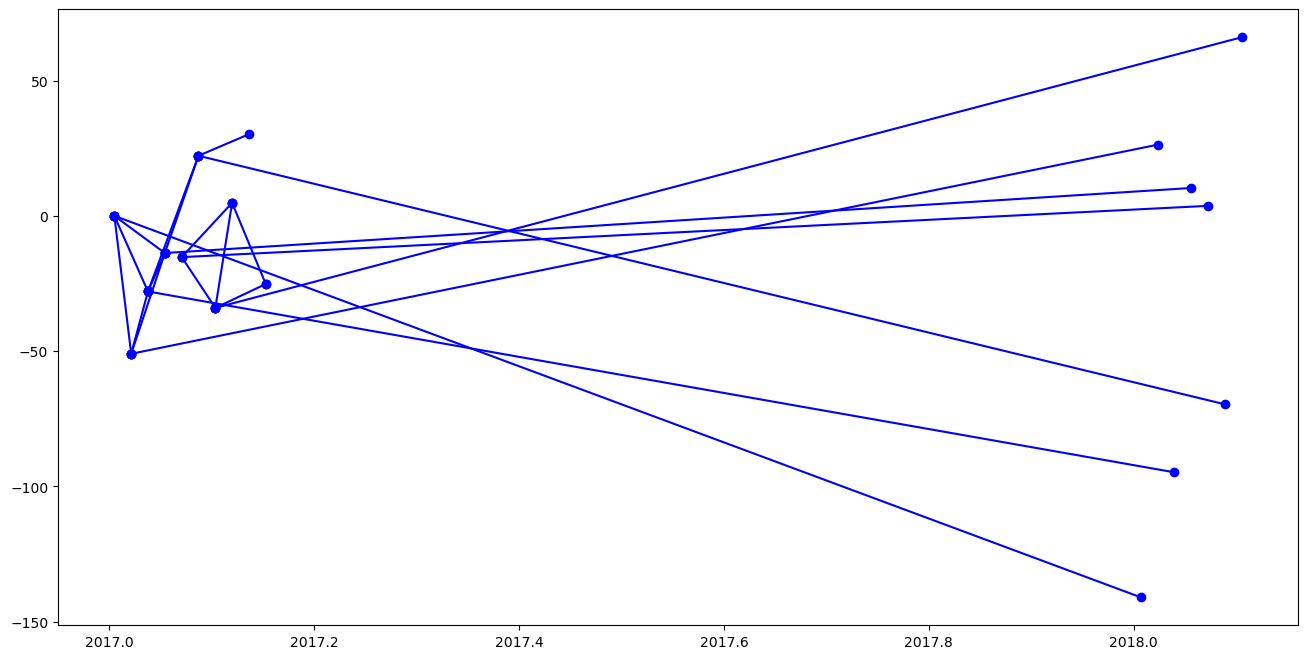

In [96]:
print("\033[1m" + 'Creating differential model observations for each ifg pair' + "\033[0m")
generate_diff_model('inputs/ERA5.h5',
                          'rERA5.h5',
                          date12_list[:n_ix],
                          bperp12[:n_ix],
                          length,
                          width,
                          metadata,
                          drop_flag[:n_ix])
#Plot
obj_plot_network('rERA5.h5')

In [97]:
print("\033[1m" + 'Invert differential model observations' + "\033[0m")
run_ifgram_inversion('rERA5.h5', 'tERA5.h5')

Invert differential model observations
open ifgramStack file: rERA5.h5
number of interferograms: 21
number of acquisitions  : 17
number of lines   : 3926
number of columns : 5534
--------------------------------------------------
create HDF5 file: tERA5.h5 with w mode
create dataset  : date       of |S8                       in size of (17,)                with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (17,)                with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (17, 3926, 5534)     with compression = None
close  HDF5 file: tERA5.h5
reference pixel in y/x: (2764, 2142) from dataset: unwrapPhase
maximum memory size: 2.0E+00 GB
split 3926 lines into 5 patches for processing
    with each patch up to 790 lines


  0%|          | 0/5 [00:00<?, ?it/s]


------- processing patch 1 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 0, 5534, 790) * 21 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 3599837 out of 4371860 (82.3%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (3599285 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 10000 pixels: 360 chunks in total ...
chunk 70 / 360
chunk 140 / 360
chunk 210 / 360
chunk 280 / 360
chunk 350 / 360
estimating time-series for pixels with valid unwrapPhase in some ifgrams (552 pixels; 0.0%) ...
[==================================================] 552/552 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.h5 in a mode
writing dataset /timeseries         

 20%|██        | 1/5 [00:16<01:07, 16.96s/it]

close HDF5 file tERA5.h5.

------- processing patch 2 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 790, 5534, 1580) * 21 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 4371860 out of 4371860 (100.0%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (4370783 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 10000 pixels: 438 chunks in total ...
chunk 90 / 438
chunk 180 / 438
chunk 270 / 438
chunk 360 / 438
estimating time-series for pixels with valid unwrapPhase in some ifgrams (1077 pixels; 0.0%) ...
[==================================================] 1077/1077 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.h5 in a mode
writing dataset /ti

 40%|████      | 2/5 [00:32<00:48, 16.33s/it]

close HDF5 file tERA5.h5.

------- processing patch 3 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 1580, 5534, 2370) * 21 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 4371860 out of 4371860 (100.0%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (4370448 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 10000 pixels: 438 chunks in total ...
chunk 90 / 438
chunk 180 / 438
chunk 270 / 438
chunk 360 / 438
estimating time-series for pixels with valid unwrapPhase in some ifgrams (1412 pixels; 0.0%) ...
[==================================================] 1412/1412 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.h5 in a mode
writing dataset /t

 60%|██████    | 3/5 [00:48<00:32, 16.25s/it]

close HDF5 file tERA5.h5.

------- processing patch 4 out of 5 --------------
box width:  5534
box length: 790
reading unwrapPhase in (0, 2370, 5534, 3160) * 21 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 4371859 out of 4371860 (100.0%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (4369497 pixels; 99.9%) ...
calculating temporalCoherence in chunks of 10000 pixels: 437 chunks in total ...
chunk 90 / 437
chunk 180 / 437
chunk 270 / 437
chunk 360 / 437
estimating time-series for pixels with valid unwrapPhase in some ifgrams (2362 pixels; 0.1%) ...
[==================================================] 2362/2362 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------
open  HDF5 file tERA5.h5 in a mode
writing dataset /ti

 80%|████████  | 4/5 [01:05<00:16, 16.47s/it]

close HDF5 file tERA5.h5.

------- processing patch 5 out of 5 --------------
box width:  5534
box length: 766
reading unwrapPhase in (0, 3160, 5534, 3926) * 21 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
skip pixels with unwrapPhase = NaN in all interferograms
number of pixels to invert: 3506429 out of 4239044 (82.7%)
estimating time-series for pixels with valid unwrapPhase in all  ifgrams (3505444 pixels; 100.0%) ...
calculating temporalCoherence in chunks of 10000 pixels: 351 chunks in total ...
chunk 70 / 351
chunk 140 / 351
chunk 210 / 351
chunk 280 / 351
chunk 350 / 351
estimating time-series for pixels with valid unwrapPhase in some ifgrams (985 pixels; 0.0%) ...
[==================================================] 985/985 pixels    0s /     0s 
converting LOS phase unit from radian to meter
returning model observations unit from radian to meter
--------------------------------------------------

100%|██████████| 5/5 [01:20<00:00, 16.01s/it]


open  HDF5 file tERA5.h5 in a mode
writing dataset /timeseries                block: [0, 17, 3160, 3926, 0, 5534]
close HDF5 file tERA5.h5.


open timeseries file: tERA5.h5


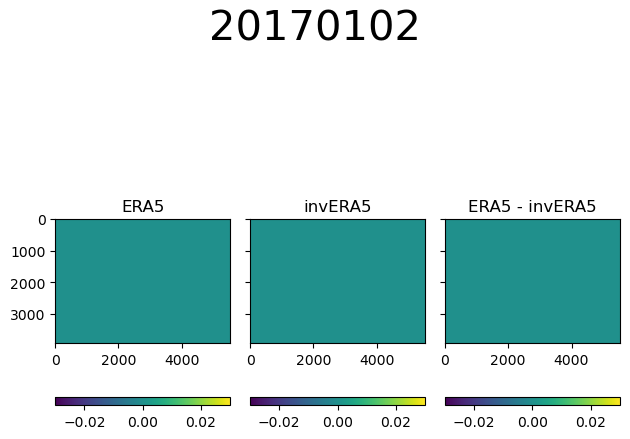

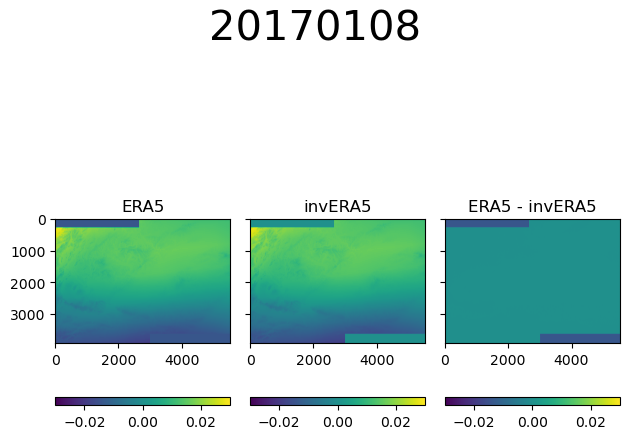

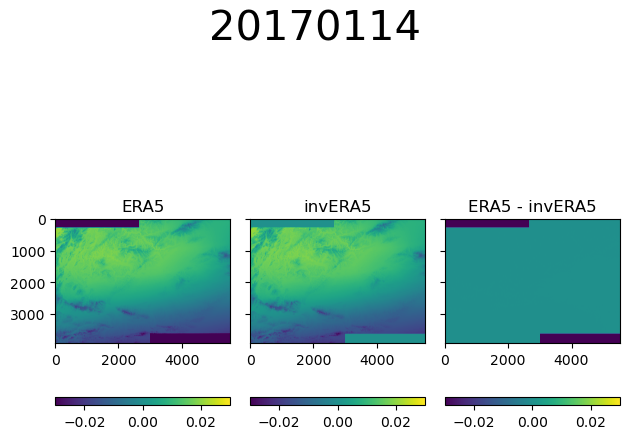

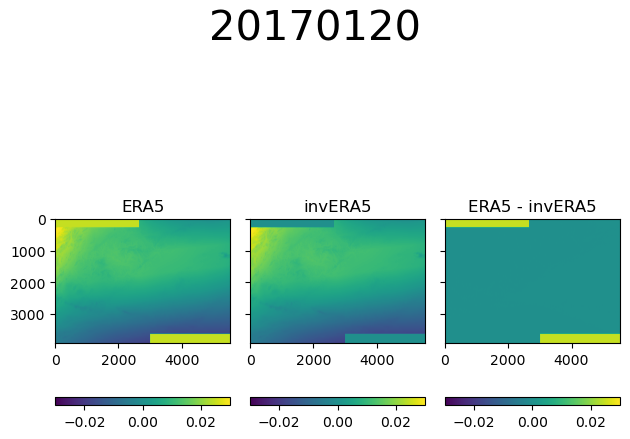

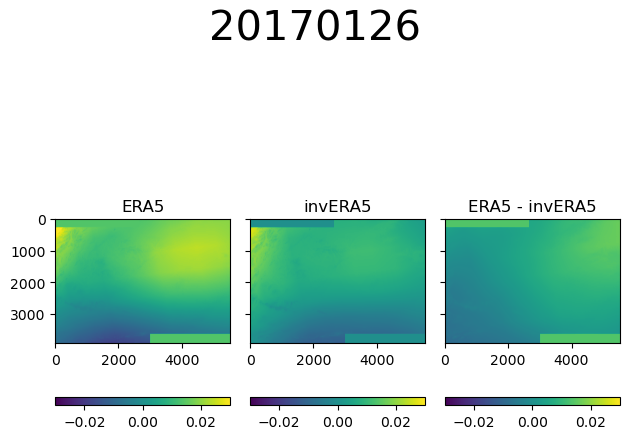

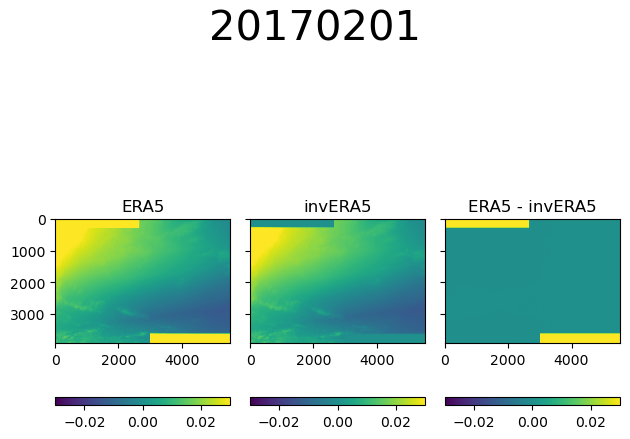

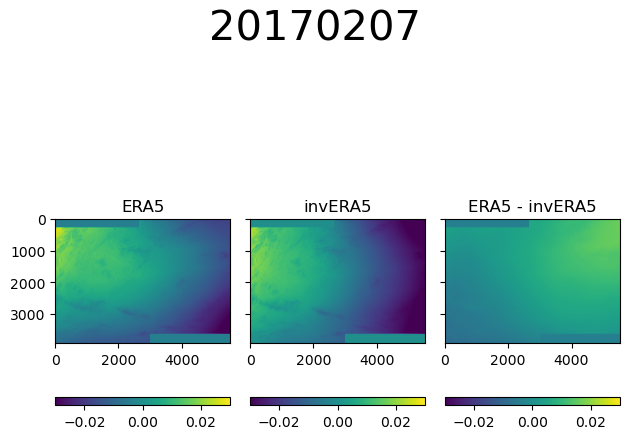

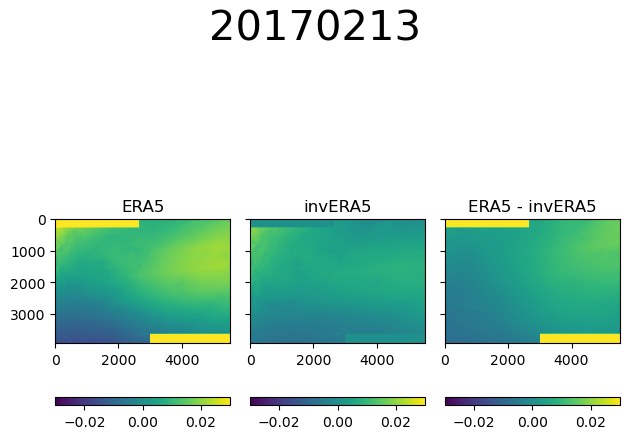

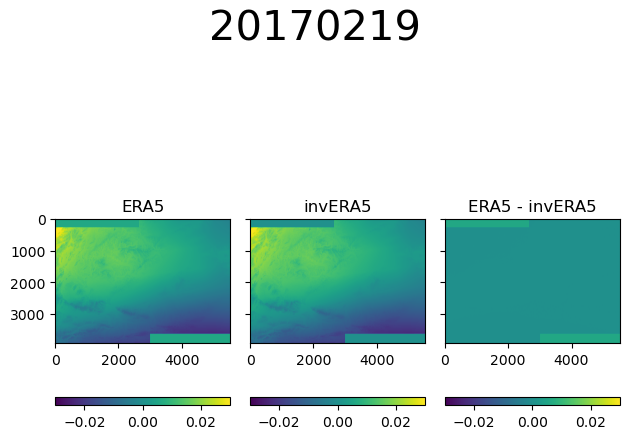

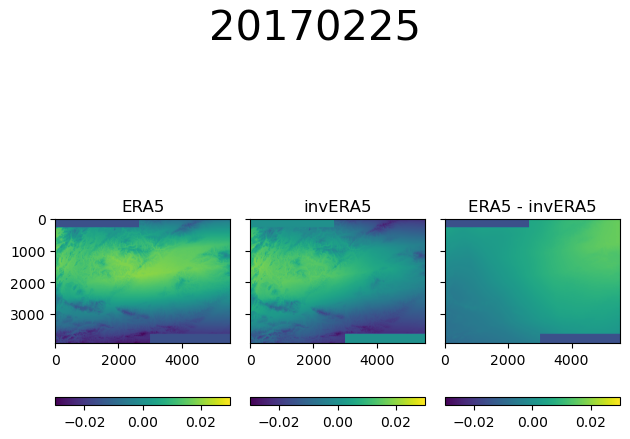

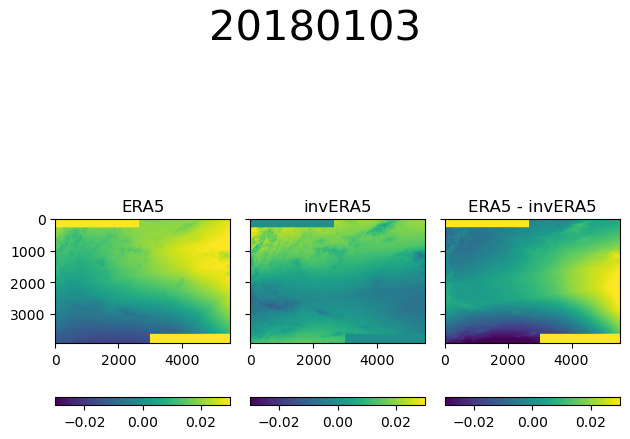

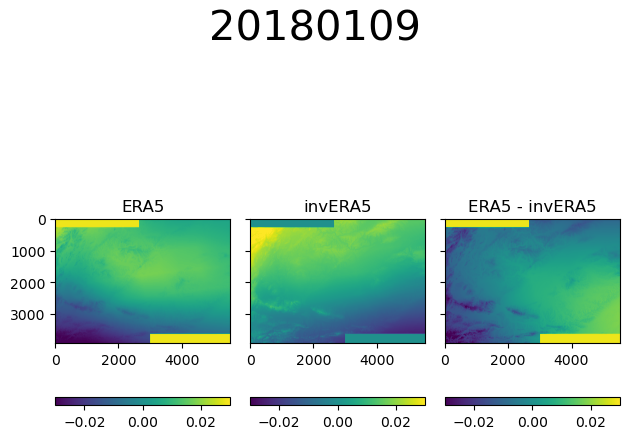

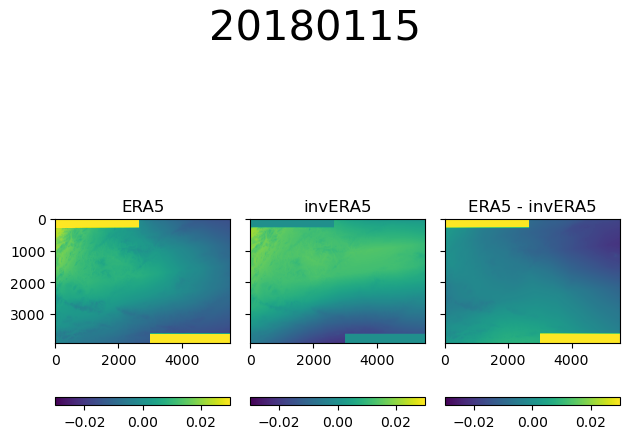

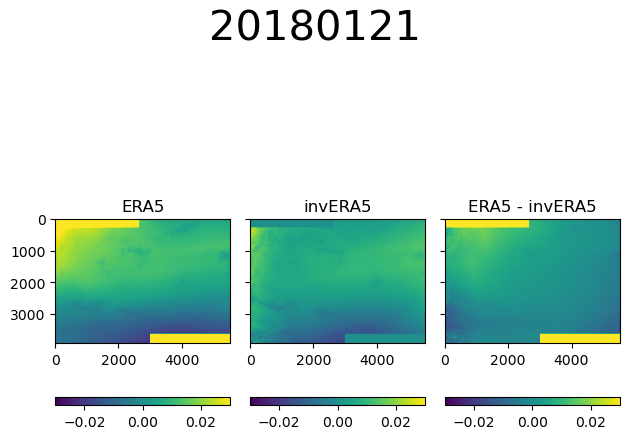

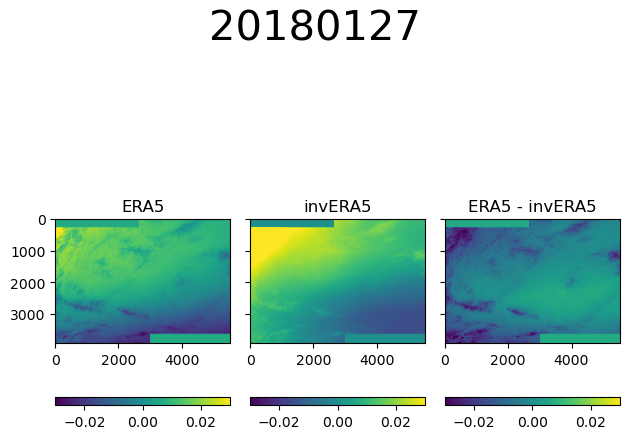

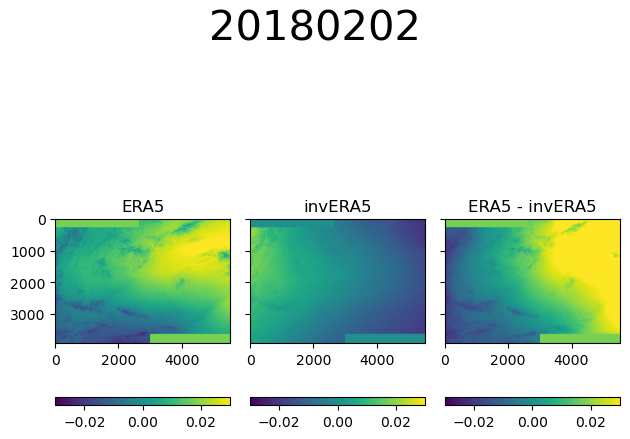

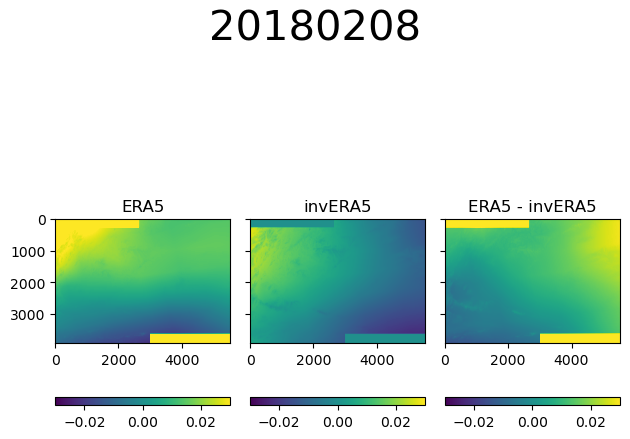

In [98]:
'''
It looks like estimate of bperp for SAR acquistion date gets wrong if the network is not connected

Network needs to be connected, spearate cluster gets wrong estimates
'''
#READ inital and output dataset

era5 = readfile.read('inputs/ERA5.h5', datasetName='timeseries')
t_era5 =readfile.read('tERA5.h5', datasetName='timeseries')

#Get dates
modelObj = timeseries('tERA5.h5')  #model.h5
modelObj.open()
dates = modelObj.dateList

#Plot
for e1, e2, d in zip(era5[0], t_era5[0], dates):
    plot_tropo(e1,
               e2,
               era5[0][0], #select the first date as reference to get relative delay from ERA5.h5
               ref_y, 
               ref_x,
               d) 

## Test out second function for inversion

In [99]:
#Create input class
class diff_model():
    '''
    differential model object for ifgram_inversion to obtain
    relative (with respect to ref_date) obs on SAR acquisition date
    '''
    def __init__(self, 
                input: str, 
                output: str,
                cluster: str = None,
                num_workers: str = '4'):

        # input
        self.ifgramStackFile = input 
        self.obsDatasetName = 'unwrapPhase' #only this available for use at the moment
        self.skip_ref = False

        # solver
        self.minNormVelocity = False
        self.minRedundancy = 1.0 
        # Note: minRedun set to 2.0 gives wrong estim, and dask has some errors
        self.weightFunc = 'no'
        self.calcCov = False

        # mask
        self.waterMaskFile = None
        self.maskDataset = None
        self.maskThreshold = 0.4

        # cluster - Expose / leave None for now
        self.cluster = cluster
        self.maxMemory = 2
        self.numWorker = num_workers
        self.config = 'local' #not sure what to put here

        # outputs
        #Avoid setting 'no' for invQualityFile 
        #self.invQualityFile = 'modelTempCoh.h5' # not needed, maybe leave it to avoid dask outout issues
        self.invQualityFile = 'no' 
        self.numInvFile = 'numInvModel.h5'
        self.tsFile = output

    def invert(self):
        import h5py, os
        from mintpy.utils import readfile, ptime, writefile
        from mintpy.ifgram_inversion import run_ifgram_inversion
        
        # remove if exists
        try:
            os.remove(self.tsFile)
            print('Delete existing file')
        except FileNotFoundError:
            print("File is not present in the system.")

        #invert differential model obs
        run_ifgram_inversion(self)

        #compensate for range2phase

        print('Return back units to original')
        data, metadata = readfile.read(self.tsFile, datasetName='timeseries')
        phase2range = -1 * float(metadata['WAVELENGTH']) / (4.*np.pi)
        
        #Replace values
        with h5py.File(self.tsFile, 'r+') as f:
            f['timeseries'][:] = data / phase2range
        
        # clean up uncessary files
        os.remove(self.invQualityFile)
        os.remove(self.numInvFile)

    def get_dates_w1pair(self):
        modelObj = ifgramStack(self.ifgramStackFile)  #model.h5
        modelObj.open(print_msg=False)

        #Get dates
        date12_list = modelObj.get_date12_list(dropIfgram=True)
        date_list = modelObj.get_date_list(dropIfgram=True) # get SAR acquisiton dates
        A = modelObj.get_design_matrix4timeseries(date12_list)[0]

        modelObj.close() 
        # find the way to check if the network is connected
        ix = np.where(np.sum(np.abs(A), axis=0) < 2)[0] + 1 # add 1 to acocunt for the first date (reference)    

        return np.array(date_list)[ix]


Creating differential model observations for each ifg pair
Creating rERA5.h5
--------------------------------------------------
create HDF5 file: rERA5.h5 with w mode
create dataset  : date        of |S8                       in size of (30, 2)              with compression = None
create dataset  : bperp       of <class 'numpy.float32'>   in size of (30,)                with compression = None
create dataset  : dropIfgram  of <class 'numpy.bool_'>     in size of (30,)                with compression = None
create dataset  : unwrapPhase of <class 'numpy.float32'>   in size of (30, 3926, 5534)     with compression = None
close  HDF5 file: rERA5.h5


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]

Number of pairs: 30
2017-01-01 : 0.0 |-| 2017-01-08 : -50.986755
2017-01-01 : 0.0 |-| 2017-01-13 : -27.955963
2017-01-01 : 0.0 |-| 2017-01-20 : -13.75345
2017-01-01 : 0.0 |-| 2018-01-02 : -140.9761
2017-01-08 : -50.986755 |-| 2017-01-13 : -27.955963
2017-01-08 : -50.986755 |-| 2017-01-20 : -13.75345
2017-01-08 : -50.986755 |-| 2017-01-26 : -59.976677
2017-01-08 : -50.986755 |-| 2018-01-09 : 26.282059
2017-01-13 : -27.955963 |-| 2017-01-20 : -13.75345
2017-01-13 : -27.955963 |-| 2017-01-26 : -59.976677
2017-01-13 : -27.955963 |-| 2017-01-31 : 22.195833
2017-01-13 : -27.955963 |-| 2018-01-14 : -94.78819
2017-01-20 : -13.75345 |-| 2017-01-26 : -59.976677
2017-01-20 : -13.75345 |-| 2017-01-31 : 22.195833
2017-01-20 : -13.75345 |-| 2017-02-07 : -78.73982
2017-01-20 : -13.75345 |-| 2018-01-21 : 10.293346
2017-01-26 : -59.976677 |-| 2017-01-31 : 22.195833
2017-01-26 : -59.976677 |-| 2017-02-07 : -78.73982
2017-01-26 : -59.976677 |-| 2017-02-12 : -39.903694
2017-01-26 : -59.976677 |-| 2018-01-

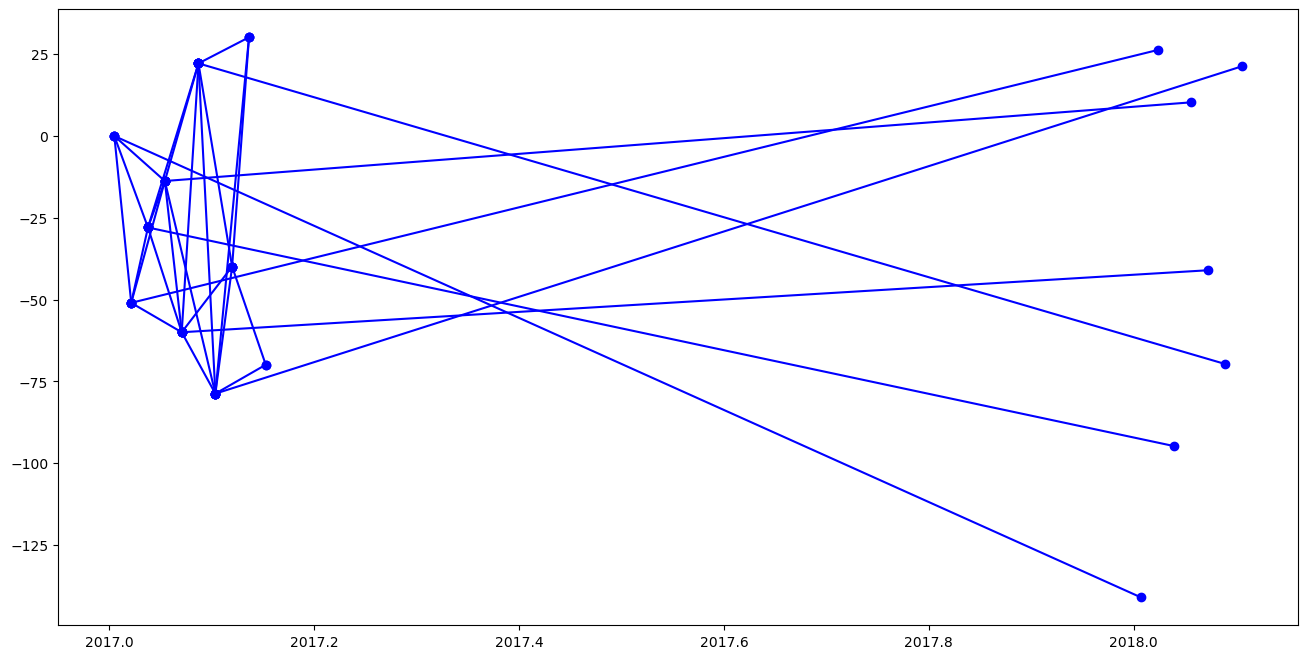

In [101]:
n_ix = 30
print("\033[1m" + 'Creating differential model observations for each ifg pair' + "\033[0m")
generate_diff_model('inputs/ERA5.h5',
                          'rERA5.h5',
                          date12_list[:n_ix],
                          bperp12[:n_ix],
                          length,
                          width,
                          metadata)

# PLOT
obj_plot_network('rERA5.h5')

In [102]:
model = diff_model('rERA5.h5', 'tERA5.h5', 'local', '20')
model.__dict__

{'ifgramStackFile': 'rERA5.h5',
 'obsDatasetName': 'unwrapPhase',
 'skip_ref': False,
 'minNormVelocity': False,
 'minRedundancy': 1.0,
 'weightFunc': 'no',
 'calcCov': False,
 'waterMaskFile': None,
 'maskDataset': None,
 'maskThreshold': 0.4,
 'cluster': 'local',
 'maxMemory': 2,
 'numWorker': '20',
 'config': 'local',
 'invQualityFile': 'no',
 'numInvFile': 'numInvModel.h5',
 'tsFile': 'tERA5.h5'}

In [103]:
# Get dates that can get bad estimates
model.get_dates_w1pair()

array(['20180103', '20180109', '20180115', '20180121', '20180127',
       '20180202', '20180208'], dtype='<U8')

In [104]:
# Invert
model.invert()

Delete existing file
save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
reference pixel in y/x: (2764, 2142) from dataset: unwrapPhase
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation phase
minimum redundancy: 1.0
weight function: no
calculate covariance: False 
mask: no
-------------------------------------------------------------------------------
number of interferograms: 30
number of acquisitions  : 17
number of lines   : 3926
number of columns : 5534
--------------------------------------------------
create HDF5 file: tERA5.h5 with w mode
create dataset  : date       of |S8                       in size of (17,)                with compression = None
create dataset  : bper

2023-02-01 16:28:15,607 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/distributed/worker.py", line 1215, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/distributed/utils_comm.py", line 400, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages

close dask cluster
------- finished parallel processing -------


--------------------------------------------------
open  HDF5 file tERA5.h5 in a mode
writing dataset /timeseries                block: [0, 17, 1580, 2370, 0, 5534]
close HDF5 file tERA5.h5.
--------------------------------------------------
open  HDF5 file no in a mode
writing dataset /temporalCoherence         block: [1580, 2370, 0, 5534]
close HDF5 file no.
--------------------------------------------------
open  HDF5 file numInvModel.h5 in a mode
writing dataset /mask                      block: [1580, 2370, 0, 5534]
close HDF5 file numInvModel.h5.
time used: 00 mins 17.7 secs.


------- processing patch 4 out of 5 --------------
box width:  5534
box length: 790


------- start parallel processing using Dask -------
input Dask cluster type: local
initiate Dask cluster
split patch into 20 sub boxes in x direction for workers to process
scale Dask cluster to 20 workers
initiate Dask client
submit a job to the worker fo

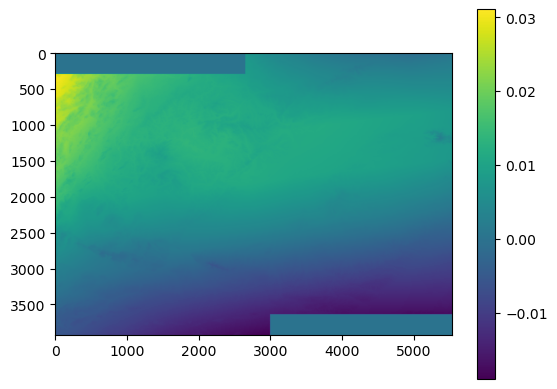

In [105]:
# Make sure inversion works
t_era5 =readfile.read('tERA5.h5', datasetName='timeseries')
plt.imshow(t_era5[0][3])
plt.colorbar()

In [106]:
#READ inital and output dataset

era5 = readfile.read('inputs/ERA5.h5', datasetName='timeseries')
#t_era5 =readfile.read('tERA5.h5', datasetName='timeseries')

#Get dates
modelObj = timeseries('tERA5.h5')  #model.h5
modelObj.open()
dates = modelObj.dateList

#Plot
for e1, e2, d in zip(era5[0], t_era5[0], dates):
    plot_tropo(e1,
               e2,
               era5[0][0], #select the first date as reference to get relative delay from ERA5.h5
               ref_y, 
               ref_x,
               d) 